In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import datetime
from sqlalchemy import create_engine

In [2]:
# connecting to the database
cnx = create_engine('mysql+pymysql://root:@localhost/dukapaq_db')    

#### Daily Transactions

In [3]:
df_transactions=pd.read_sql("SELECT * FROM transactions", cnx)
#df_transactions.query('company_id==3')
df_transactions['created_at']=pd.to_datetime(df_transactions['created_at'])
df_transactions['transaction_month']=pd.to_datetime(df_transactions['created_at']).dt.month
df_transactions['transaction_day']=pd.to_datetime(df_transactions['created_at']).dt.day
# #Deneric company ID=3

daily_transactions=df_transactions.query('company_id==3')

In [4]:
daily_transactions.head()

,id,tran_type,account_id,amount,description,debit,credit,balance,date,customer_id,supplier_id,order_id,created_at,updated_at,company_id,transaction_month,transaction_day
41,61,Income,1,1500.0,POS order,0,1,1500.0,2023-02-06,5001.0,None,1.675682e+09,2023-02-06 20:11:26,2023-02-06 20:11:26,3.0,2,6
42,62,Income,1,1100.0,POS order,0,1,1100.0,2023-02-06,5001.0,None,1.675682e+09,2023-02-06 20:17:02,2023-02-06 20:17:02,3.0,2,6
47,67,Income,1,3885.0,POS order,0,1,3885.0,2023-02-06,5001.0,None,1.675689e+09,2023-02-06 22:04:16,2023-02-06 22:04:16,3.0,2,6
49,69,Income,23,1045.0,POS order,0,1,1145.0,2023-02-07,5001.0,None,1.675772e+09,2023-02-07 21:13:07,2023-02-07 21:13:07,3.0,2,7
50,70,Income,24,2520.0,POS order,0,1,2620.0,2023-02-07,5001.0,None,1.675772e+09,2023-02-07 21:20:22,2023-02-07 21:20:22,3.0,2,7


In [5]:
daily_transactions=daily_transactions.groupby(['transaction_day','tran_type'])['amount'].sum().reset_index()
daily_transactions

,transaction_day,tran_type,amount
0,6,Income,6485.0
1,7,Income,3565.0
2,8,Income,2725.0
3,9,Income,14865.0
4,10,Income,2625.0
5,11,Income,3565.0


#### Total Daily Revenue

In [6]:
daily_revenue=daily_transactions.groupby(['transaction_day'])['amount'].sum().reset_index()
daily_revenue

,transaction_day,amount
0,6,6485.0
1,7,3565.0
2,8,2725.0
3,9,14865.0
4,10,2625.0
5,11,3565.0


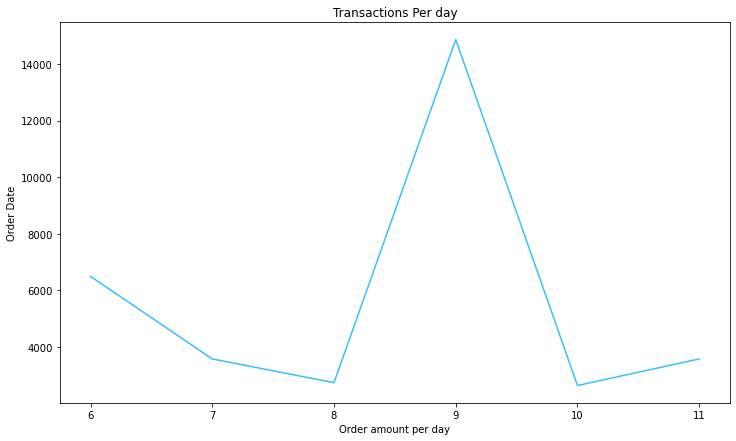

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(data=daily_revenue, y='amount', x='transaction_day', color='#33C1FF')
#sns.lineplot(data=daily_orders, y='collected_cash', x='order_date', color='#33C1FF', ax=ax)

plt.title("Transactions Per day")
plt.xlabel("Order amount per day")
plt.ylabel("Order Date")
plt.show()


#### Inventory Total Amount

In [8]:
df_Products=pd.read_sql('SELECT * FROM products', cnx)

In [9]:

def extract_id_values(row):
    data_list = pd.io.json.loads(row)
    values = [d['id'] for d in data_list]
    return pd.Series(values)

temp_df = df_Products['category_ids'].apply(extract_id_values).apply(pd.Series)
temp_df = temp_df.rename(columns = lambda x : 'id_values_' + str(x))
result = pd.concat([df_Products, temp_df], axis=1)
result.head(2)

,id,name,product_code,unit_type,unit_value,brand,category_ids,purchase_price,selling_price,discount_type,...,tax,quantity,image,order_count,supplier_id,created_at,updated_at,company_id,id_values_0,id_values_1
0,1,Banana,347653,1,878.0,1,"[{""id"":""1"",""position"":""1""},{""id"":""2"",""position...",18.0,747.0,amount,...,0.0,457,def.png,24,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,1,2
1,2,Milk,974689,1,799.0,1,"[{""id"":""1"",""position"":""1""},{""id"":""2"",""position...",130.0,808.0,amount,...,0.0,251,def.png,26,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,1,2


In [10]:
df_categories=pd.read_sql("SELECT * FROM categories", cnx)
df_categories['id_values_0']=df_categories['id']
#deneric_categoriess=df_categories.query('company_id==3')
#deneric_categoriess

In [11]:
#result.info()

In [12]:
result['id_values_0'] = result['id_values_0'].astype(int)
total_inventory_amount = pd.merge(df_categories, result, on='id_values_0', how='inner')
total_inventory_amount.head(2)

,id_x,name_x,parent_id,position,status,image_x,created_at_x,updated_at_x,company_id_x,id_values_0,...,discount,tax,quantity,image_y,order_count,supplier_id,created_at_y,updated_at_y,company_id_y,id_values_1
0,1,Fruits,0,0,1,2022-11-30-63876a81a5abc.png,2022-11-30 23:36:49,2023-01-20 05:03:40,1.0,1,...,10.0,0.0,457,def.png,24,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,2
1,1,Fruits,0,0,1,2022-11-30-63876a81a5abc.png,2022-11-30 23:36:49,2023-01-20 05:03:40,1.0,1,...,10.0,0.0,251,def.png,26,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,2


In [13]:
inventory_amount=total_inventory_amount[['name_x','name_y','quantity','order_count','company_id_x']]
#Renaming columns
# deneric_inventory_amount.columns('Category','Product','Quantity','Orders made','Company_id')
inventory_amount.rename(columns={'name_x': 'categories', 'name_y': 'products','company_id_x':'company_id'}, inplace=True)
inventory_amount

C:\Users\user\AppData\Local\Temp\ipykernel_2284\959002380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_amount.rename(columns={'name_x': 'categories', 'name_y': 'products','company_id_x':'company_id'}, inplace=True)


,categories,products,quantity,order_count,company_id
0,Fruits,Banana,457,24,1.0
1,Fruits,Milk,251,26,1.0
2,Fruits,Oranges,5,7,1.0
3,Fruits,Chicken,114,3,1.0
4,Fruits,tomato,40,9,1.0
...,...,...,...,...,...
191,Vodka,Konyagi 500ml,1,0,9.0
192,Vodka,Triple Ace 250ml,2,1,9.0
193,Vodka,Kibao 750ml,2,0,9.0
194,Vodka,Smirnoff Vodka 750ml,1,0,9.0


In [14]:
deneric_inventory_amount=inventory_amount.query('company_id==3')
deneric_inventory_amount

,categories,products,quantity,order_count,company_id
86,PRINTING,WIDE BASE ROLL-UP,1000,0,3.0
87,DESIGN,Flyers,840,2,3.0
88,SIGNAGE & MARKETING,STICKER 1*1,996,3,3.0
89,SIGNAGE & MARKETING,BANNER 1*1,997,2,3.0
90,CLOTHING & WEARABLE,LANYARD,1000,0,3.0
91,CLOTHING & WEARABLE,CLOTHING PRINTING,998,1,3.0
92,CLOTHING & WEARABLE,REFLECTORS,1000,0,3.0
93,CLOTHING & WEARABLE,KIDS JERSEY,1000,0,3.0
94,CLOTHING & WEARABLE,JERSEY,998,1,3.0
95,CLOTHING & WEARABLE,ROUND NECK T-SHIRT,997,3,3.0


#### Inventory Total Revenue Amount

In [15]:
inventory_amount_revenue=pd.merge(df_transactions, inventory_amount, on='company_id', how='inner')
#total_inventory_amount_revenue = inventory_amount_revenue.groupby('order_count').sum['amount'].reset_index(level=0, name='total_amount')
inventory_amount_revenue['total_amount']=inventory_amount_revenue['amount']*inventory_amount_revenue['order_count']
inventory_amount_revenue
total_inventory_amount_revenue=inventory_amount_revenue[['company_id','categories','products', 'order_count','amount','total_amount']]
total_inventory_amount_revenue.head(2)

,company_id,categories,products,order_count,amount,total_amount
0,1.0,Fruits,Banana,24,193.0,4632.0
1,1.0,Fruits,Milk,26,193.0,5018.0


In [16]:
deneric_total_inventory_amount_revenue=total_inventory_amount_revenue.query('company_id==3')
deneric_total_inventory_amount_revenue

,company_id,categories,products,order_count,amount,total_amount
2079,3.0,PRINTING,WIDE BASE ROLL-UP,0,1500.0,0.0
2080,3.0,DESIGN,Flyers,2,1500.0,3000.0
2081,3.0,SIGNAGE & MARKETING,STICKER 1*1,3,1500.0,4500.0
2082,3.0,SIGNAGE & MARKETING,BANNER 1*1,2,1500.0,3000.0
2083,3.0,CLOTHING & WEARABLE,LANYARD,0,1500.0,0.0
...,...,...,...,...,...,...
2347,3.0,CLOTHING & WEARABLE,JERSEY,1,3565.0,3565.0
2348,3.0,CLOTHING & WEARABLE,ROUND NECK T-SHIRT,3,3565.0,10695.0
2349,3.0,CLOTHING & WEARABLE,HOODIE,2,3565.0,7130.0
2350,3.0,CLOTHING & WEARABLE,POLO T-SHIRT,11,3565.0,39215.0


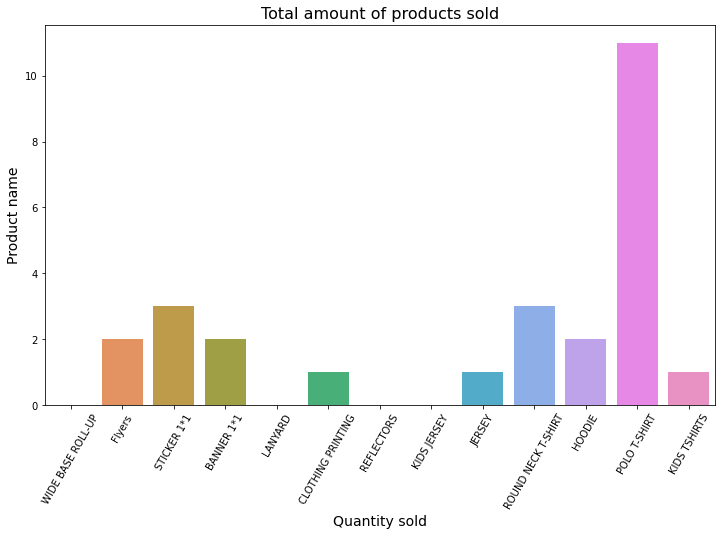

In [17]:
plt.subplots(figsize=(12, 7))
sns.barplot(data=deneric_total_inventory_amount_revenue, x='products', y='order_count')
plt.title("Total amount of products sold", size=16)
plt.xlabel("Quantity sold", size=14)
plt.xticks(rotation=60, size=10)
plt.ylabel("Product name", size=14)
plt.show()